In [1]:
from textwrap import wrap
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import colors
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import missingno as msno
from scipy import stats
import seaborn as sns


In [4]:
plt.style.use('ggplot')

def human_format(num, row):
    magnitude = 0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000.0
    return '$%.2f%s' % (num, ['', 'K', 'M', 'B', 'T'][magnitude])
human_formatter = mtick.FuncFormatter(human_format)
comma_formatter = mpl.ticker.StrMethodFormatter('{x:,.0f}')
dollar_formatter = mtick.StrMethodFormatter('${x:,.0f}')

df = pd.read_csv('grants.csv', index_col=0)


In [5]:
def summary(df):
    print(f'data shape: {df.shape}')
    summ = pd.DataFrame(df.dtypes, columns=['Data Type'])
    summ['Missing#'] = df.isna().sum()
    summ['Missing%'] = (df.isna().sum())/len(df)
    summ['Dups'] = df.duplicated().sum()
    summ['Uniques'] = df.nunique().values
    summ['Count'] = df.count().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['Min'] = desc['min'].values
    summ['Max'] = desc['max'].values
    summ['Average'] = desc['mean'].values
    summ['Standard Deviation'] = desc['std'].values
    summ['First Value'] = df.loc[0].values
    summ['Second Value'] = df.loc[1].values
    summ['Third Value'] = df.loc[2].values
    display(summ)
    
summary(df)

data shape: (75640, 21)


,Data Type,Missing#,Missing%,Dups,Uniques,Count,Min,Max,Average,Standard Deviation,First Value,Second Value,Third Value
opportunity_id,int64,0,0.000000,0,75640,75640,15936.0,351685.0,245652.21798,101553.904311,262148,262308,262368
opportunity_title,object,0,0.000000,0,62696,75640,NaN,NaN,NaN,NaN,Establishment of the Edmund S. Muskie Graduate...,Health and resiliency of salt marshes in Jamai...,Post-Hurricane Sandy submerged marine habitat ...
opportunity_number,object,0,0.000000,0,75503,75640,NaN,NaN,NaN,NaN,SCAPPD-14-AW-161-SCA-08152014,NPS-14-NERO-0119,NPS-14-NERO-0125
opportunity_category,object,0,0.000000,0,5,75640,NaN,NaN,NaN,NaN,Discretionary,Discretionary,Discretionary
funding_instrument_type,object,0,0.000000,0,4,75640,NaN,NaN,NaN,NaN,Cooperative Agreement,Cooperative Agreement,Cooperative Agreement
category_of_funding_activity,object,0,0.000000,0,26,75640,NaN,NaN,NaN,NaN,Other,Other,Other
cfda_numbers,float64,825,0.010907,0,2132,74815,0.0,98.012,48.792395,37.282771,19.04,15.945,15.945
eligible_applicants,object,0,0.000000,0,17,75640,NaN,NaN,NaN,NaN,Others,Others,Others
eligible_applicants_type,object,0,0.000000,0,3,75640,NaN,NaN,NaN,NaN,Non-Government Organization,Non-Government Organization,Non-Government Organization
agency_code,object,43,0.000568,0,681,75597,NaN,NaN,NaN,NaN,DOS-SA,DOI-NPS,DOI-NPS


In [7]:
df.isna().sum()

opportunity_id                              0
opportunity_title                           0
opportunity_number                          0
opportunity_category                        0
funding_instrument_type                     0
category_of_funding_activity                0
cfda_numbers                              825
eligible_applicants                         0
eligible_applicants_type                    0
agency_code                                43
agency_name                                44
post_date                                   0
close_date                               4012
last_updated_date                           0
archive_date                             7055
award_ceiling                           13821
award_floor                             22060
estimated_total_program_funding         22194
expected_number_of_awards               21775
cost_sharing_or_matching_requirement        0
additional_information_url              25665
dtype: int64

In [8]:
df.duplicated().sum()

0

In [12]:
len(df['opportunity_title'].unique())

62696

In [13]:
len(df['estimated_total_program_funding'].unique())

12181

<Axes: >

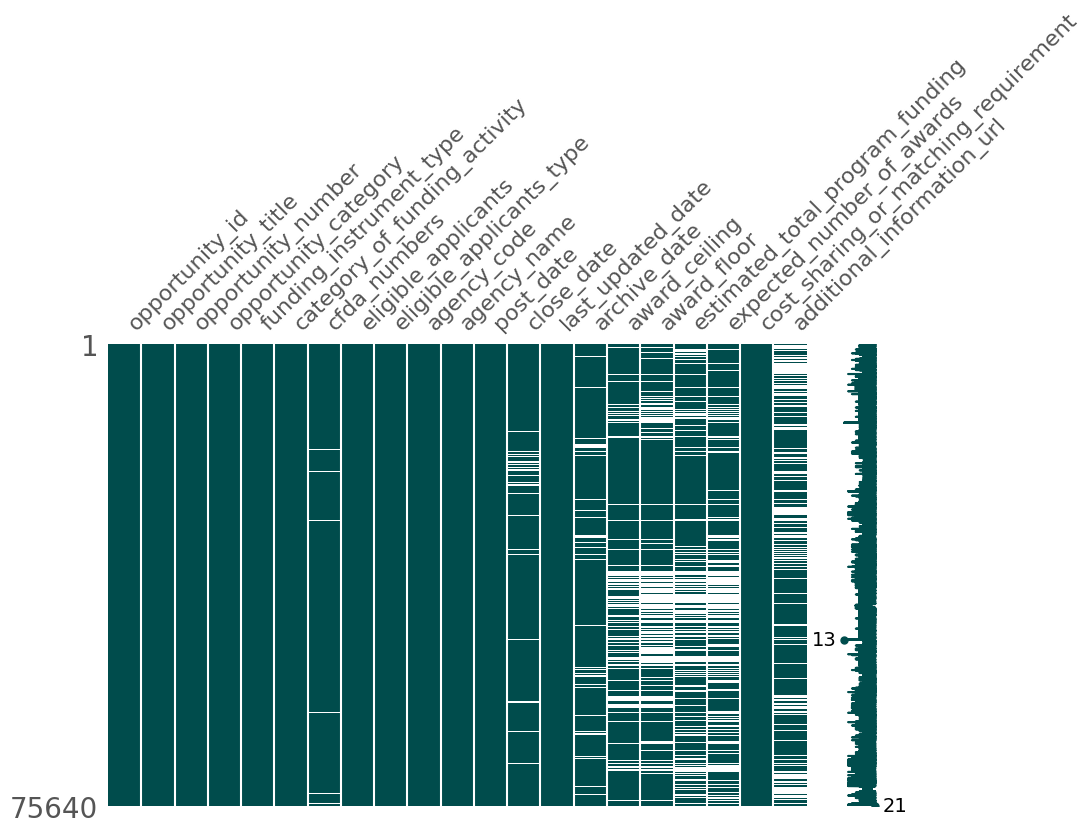

In [6]:
msno.matrix(df, figsize=(10,6), color=(0,.3,.3))

## Doing the feature engineering to optimize our analysis.

Dropping Opportunity ID that we will not use.
Converting the date-string features to datetime.
Creating post_year feature from post_date.
Filling in empty estimated_total_program_funding base on award_ceiling and expected_number_of_awards.
Creating fund_per_award feature from estimated_total_program_funding and expected_number_of_awards.

In [14]:
df = df.drop("opportunity_id", axis=1)

df["post_date"] = pd.to_datetime(df["post_date"])
df["close_date"] = pd.to_datetime(df["close_date"])
df["last_updated_date"] = pd.to_datetime(df["last_updated_date"])
df["archive_date"] = pd.to_datetime(df["archive_date"])

df["post_year"] = pd.to_datetime(df["post_date"].dt.strftime("%Y"))
df["estimated_total_program_funding"] = df.apply(
    lambda x: x["estimated_total_program_funding"]
    if x["estimated_total_program_funding"] != None and x["estimated_total_program_funding"] != 0
    else x["award_ceiling"] * x["expected_number_of_awards"],
    axis=1
)
df["fund_per_award"] = df.apply(
    lambda x: np.nan
    if x["estimated_total_program_funding"] < 1 or x["expected_number_of_awards"] < 1
    else x["estimated_total_program_funding"] / x["expected_number_of_awards"],
    axis=1,
)

## Checking for Feature Correlations
Taking a look at the feature correlations.

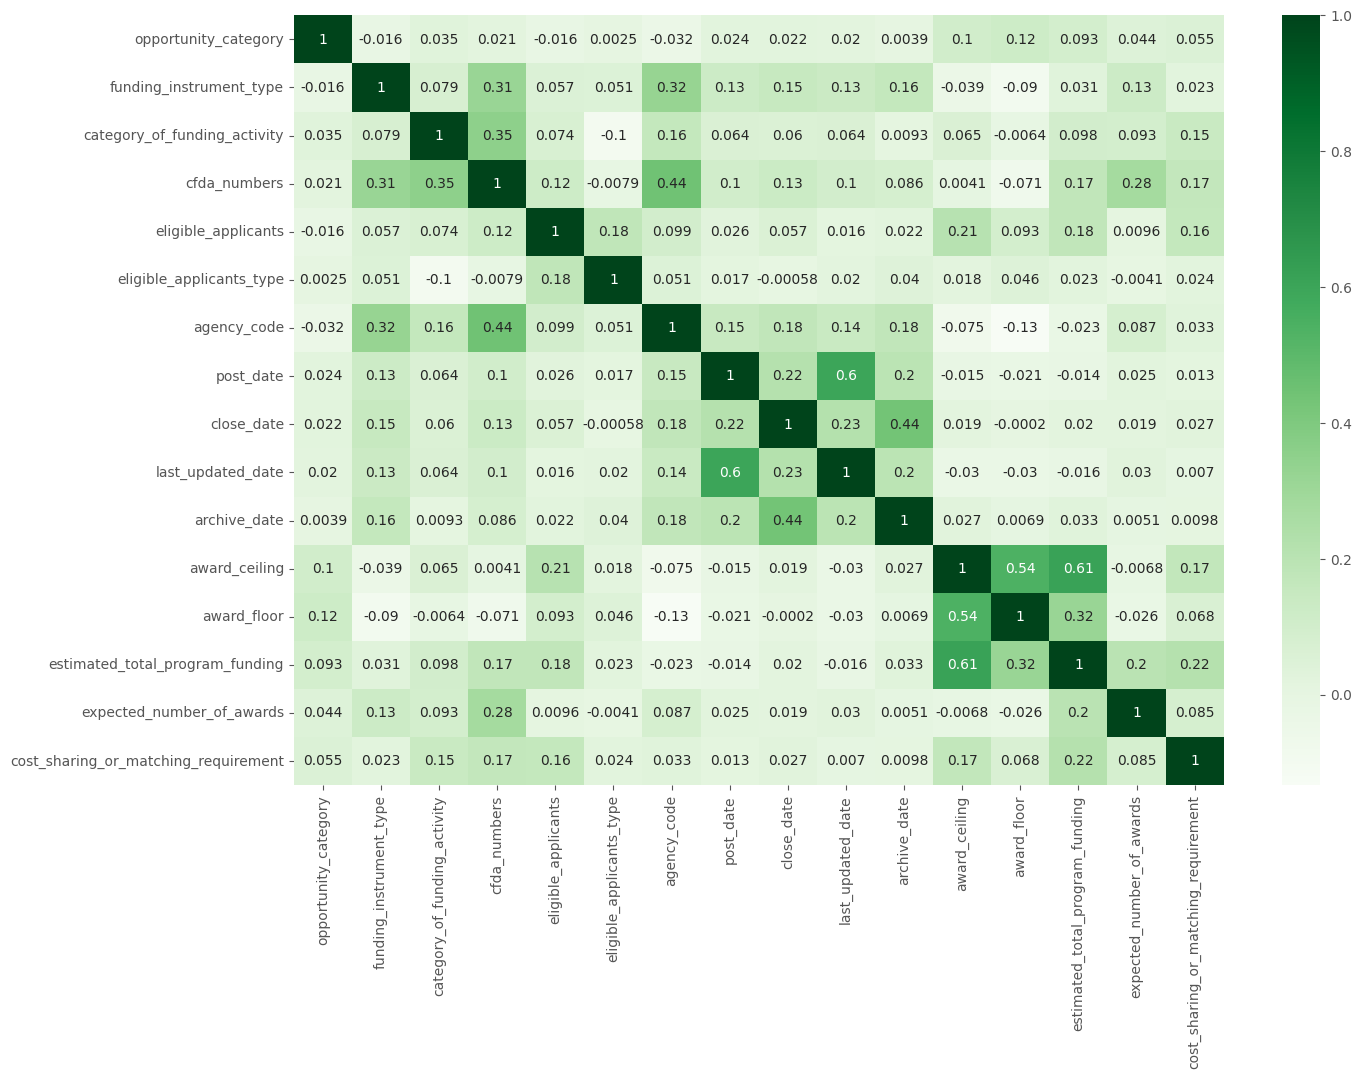

In [15]:
corr_df = df[[
        "opportunity_category", "funding_instrument_type", "category_of_funding_activity",
        "cfda_numbers", "eligible_applicants", "eligible_applicants_type", "agency_code",
        "post_date", "close_date", "last_updated_date", "archive_date", "award_ceiling", "award_floor",
        "estimated_total_program_funding", "expected_number_of_awards", "cost_sharing_or_matching_requirement",
    ]]

plt.figure(figsize=(15,10))
sns.heatmap(corr_df.apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1),annot=True, cmap="Greens")
plt.show()

## Financial Analysis and investigation then Breakdown
Total Funds per Year by Eligible Applicants
OOur primary consideration revolves around the annual funding opportunities allocated to each applicant?

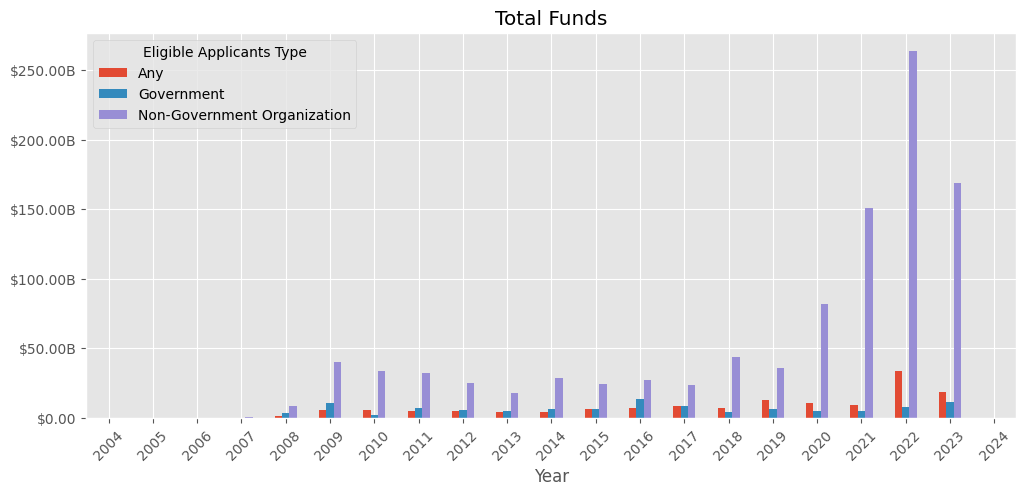

In [16]:
total_fund_df = (
    df.groupby(["post_year", "eligible_applicants_type"])["estimated_total_program_funding"]
    .sum()
    .to_frame("total_funding_per_year")
    .reset_index()
)
total_fund_df = total_fund_df.pivot(index="post_year", columns="eligible_applicants_type", values="total_funding_per_year")
fig, ax = plt.subplots(figsize=(12,5))
total_fund_df.plot(kind="bar", ax=ax)
ax.yaxis.set_major_formatter(comma_formatter) 
ax.set_xticklabels([x.strftime("%Y") for x in total_fund_df.index], rotation=45)
ax.legend(title="Eligible Applicants Type")
ax.yaxis.set_major_formatter(human_formatter) 
plt.xlabel("Year")
plt.title("Total Funds")
plt.show()


## Cumulative Aggregate Funding
A total of $1.2 trillion in funds has been made available since the year 2004.

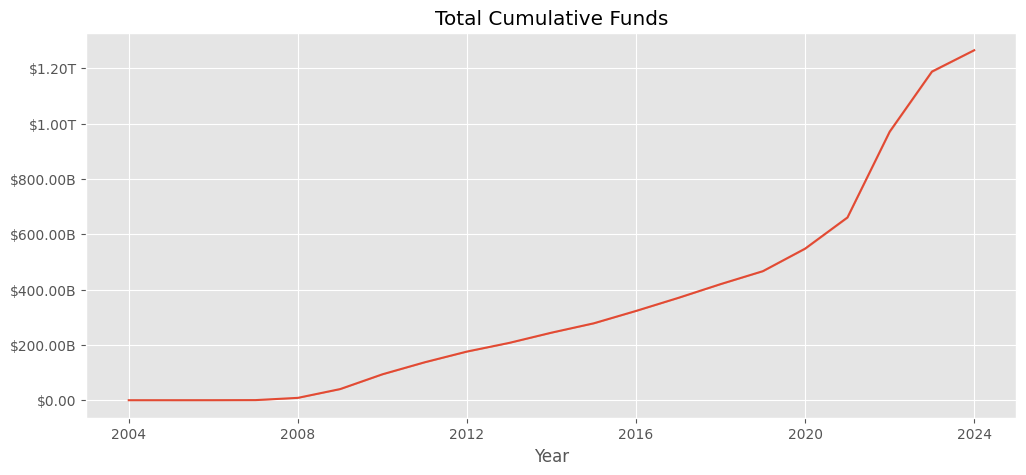

In [17]:
cumsum_fund_df = df.sort_values("post_year")[["post_year", "estimated_total_program_funding"]]
cumsum_fund_df["cumsum_fund"] = cumsum_fund_df["estimated_total_program_funding"].cumsum()
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(ax = ax, data = cumsum_fund_df, x = 'post_year', y = 'cumsum_fund')
ax.yaxis.set_major_formatter(human_formatter) 
plt.xlabel("Year")
plt.ylabel("")
plt.title("Total Cumulative Funds")
plt.show()

## Average Funding per Award

Utilizing the "expected_number_of_awards" feature, we can analyze the average fund per award across multiple years. The calculated average ranges from 2.5 million to 12 million, a notable and unexpected finding.

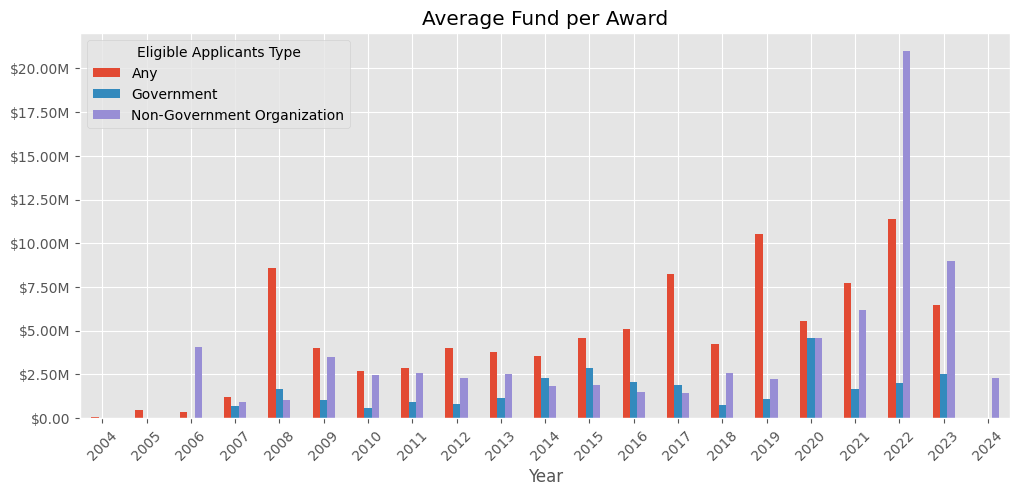

In [18]:
fpa_df = (
    df.groupby(["post_year", "eligible_applicants_type"])["fund_per_award"]
    .mean()
    .to_frame("avg_fund_per_award_per_year")
    .reset_index()
)
fpa_df = fpa_df.pivot(index="post_year", columns="eligible_applicants_type", values="avg_fund_per_award_per_year")
fig, ax = plt.subplots(figsize=(12,5))
fpa_df.plot(kind="bar", ax=ax)
ax.set_xticklabels([x.strftime("%Y") for x in fpa_df.index], rotation=45)
ax.legend(title="Eligible Applicants Type")
ax.yaxis.set_major_formatter(human_formatter) 
plt.title("Average Fund per Award")
plt.xlabel("Year")
plt.show()

## Category Examination:
The dataset encompasses various category features, necessitating a thorough examination of each category.

Analysis of Eligible Applicant Types

In [ ]:
plot_pie(df, "eligible_applicants_type", "Applicants Type")
ea_year_df = df.groupby(["post_year", "eligible_applicants_type"]).size().unstack()
plot_year_stack(ea_year_df, "Applicants Type")